In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
!unzip /content/drive/MyDrive/flickr30k_images.zip -d all_images
!unzip /content/drive/MyDrive/Flickr30k_text.zip -d all_captions

Streaming output truncated to the last 5000 lines.
  inflating: all_captions/Flickr30k_text/Flickr30k_text/annotations/Sentences/536147209.txt  
  inflating: all_captions/Flickr30k_text/Flickr30k_text/annotations/Sentences/5361551308.txt  
  inflating: all_captions/Flickr30k_text/Flickr30k_text/annotations/Sentences/536156200.txt  
  inflating: all_captions/Flickr30k_text/Flickr30k_text/annotations/Sentences/5362687336.txt  
  inflating: all_captions/Flickr30k_text/Flickr30k_text/annotations/Sentences/5363528971.txt  
  inflating: all_captions/Flickr30k_text/Flickr30k_text/annotations/Sentences/5363903246.txt  
  inflating: all_captions/Flickr30k_text/Flickr30k_text/annotations/Sentences/5364849864.txt  
  inflating: all_captions/Flickr30k_text/Flickr30k_text/annotations/Sentences/536495604.txt  
  inflating: all_captions/Flickr30k_text/Flickr30k_text/annotations/Sentences/5365075444.txt  
  inflating: all_captions/Flickr30k_text/Flickr30k_text/annotations/Sentences/536533294.txt  
  i

In [ ]:
!pip install tensorflow==2.15.0
!pip install gtts
!pip install Keras-Preprocessing
!pip install tensorflow_addons
!pip install --quiet vit-keras
!pip install "git+https://github.com/salaniz/pycocoevalcap.git"

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 475.2/475.2 MB 2.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.7/1.7 MB 75.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.0/1.0 MB 62.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 5.5/5.5 MB 111.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 442.0/442.0 kB 36.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 77.9/77.9 kB 8.2 MB/s eta 0:00:00
  Attempting uninstall: wrapt
    Found existing installation: wrapt 1.16.0
    Uninstalling wrapt-1.16.0:
      Successfully uninstalled wrapt-1.16.0
  Attempting uninstall: ml-dtypes
    Found existing installation: ml-dtypes 0.4.0
    Uninstalling ml-dtypes-0.4.0:
      Successfully uninstalled ml-dtypes-0.4.0
  Attempting uninstall: keras
    Found existing installation: keras 3.4.1
    Uninstalling keras-3.4.1:
      Successfully uninstalled keras-3.4.1
  Attempting uninstall: tensorboard
    Found existing installatio

In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from collections import Counter
import tensorflow as tf
import keras
from keras_preprocessing.image import load_img
import string
import time
from sklearn.model_selection import train_test_split
from keras.preprocessing.text import Tokenizer
from keras.models import Model
from keras import layers
from keras import activations
from keras import Input
#from keras.utils.vis_utils import plot_model
from PIL import Image
from tqdm import tqdm
import glob
from gtts import gTTS
#from playsound import playsound
from IPython import display
import collections
import wordcloud
from wordcloud import WordCloud, STOPWORDS
import numpy as np
import pandas as pd
import os
import random
import statistics
from math import sqrt
import imageio
from sklearn.model_selection import train_test_split
from sklearn.utils import shuffle
import re
import numpy as np
import os
import collections
import random
import numpy as np
import os
import time
import json
import glob
from glob import glob
from PIL import Image
import pickle
from vit_keras import vit
import warnings
import random
warnings.filterwarnings("ignore")

/usr/local/lib/python3.10/dist-packages/tensorflow_addons/utils/tfa_eol_msg.py:23: UserWarning: 

TensorFlow Addons (TFA) has ended development and introduction of new features.
TFA has entered a minimal maintenance and release mode until a planned end of life in May 2024.
Please modify downstream libraries to take dependencies from other repositories in our TensorFlow community (e.g. Keras, Keras-CV, and Keras-NLP). 

For more information see: https://github.com/tensorflow/addons/issues/2807 

  warnings.warn(


In [ ]:
import os
import shutil

# Path to the directory containing all the images
image_directory = '/content/all_images/flickr30k_images/flickr30k_images'

# Path to the file containing all the captions
caption_file = '/content/all_captions/Flickr30k_text/Flickr30k_text/captions.txt'

# Path to the text file containing the training image IDs
training_ids_file = '/content/all_captions/Flickr30k_text/Flickr30k_text/train.txt'

# Create the output folder if it doesn't exist
output_folder = 'all_data'
os.makedirs(output_folder, exist_ok=True)

# Path to the output image folder
output_image_folder = os.path.join(output_folder, 'training_images')
os.makedirs(output_image_folder, exist_ok=True)

# Path to the output text file
output_text_file = os.path.join(output_folder, 'training_captions.txt')

# Read the training image IDs from the text file
with open(training_ids_file, 'r') as f:
    training_ids = f.read().splitlines()


TRAIN_LIMIT= 10000    #29000

training_ids = training_ids[:TRAIN_LIMIT] #for limit of train ids


# Create a dictionary to store the captions for training images
captions = {}

# Read the captions from the caption file
with open(caption_file, 'r') as f:
    for line in f:
        line = line.strip()
        if line:
            image_id, caption = line.split(',', 1)
            image_id = image_id.split('.')[0]  # Remove the file extension for comparison
            if image_id in training_ids:
                if image_id not in captions:
                    captions[image_id] = []
                captions[image_id].append(caption.strip())

# Write the image IDs and captions to the output text file
with open(output_text_file, 'w') as f:
    for image_id in training_ids:
        # Form the image filename
        image_filename = f'{image_id}.jpg'

        # Copy the image to the output image folder
        src_path = os.path.join(image_directory, image_filename)
        dst_path = os.path.join(output_image_folder, image_filename)
        if os.path.exists(src_path):
            shutil.copyfile(src_path, dst_path)
        else:
            print(f"Warning: {image_filename} does not exist in {image_directory}")

        # Write the image ID and captions to the output text file
        if image_id in captions:
            caption_list = captions[image_id]
            for caption in caption_list:
                f.write(f"{image_filename},{caption}\n")
        else:
            f.write(f"{image_filename},\n")


In [ ]:

# Path to the directory containing all the images
image_directory = '/content/all_images/flickr30k_images/flickr30k_images'

# Path to the file containing all the captions
caption_file = '/content/all_captions/Flickr30k_text/Flickr30k_text/captions.txt'

# Path to the text file containing the training image IDs
training_ids_file = '/content/all_captions/Flickr30k_text/Flickr30k_text/val.txt'

# Create the output folder if it doesn't exist
output_folder = 'all_data'
os.makedirs(output_folder, exist_ok=True)

# Path to the output image folder
output_image_folder = os.path.join(output_folder, 'validation_images')
os.makedirs(output_image_folder, exist_ok=True)

# Path to the output text file
output_text_file = os.path.join(output_folder, 'validation_captions.txt')

# Read the training image IDs from the text file
with open(training_ids_file, 'r') as f:
    training_ids = f.read().splitlines()

VALID_LIMIT=1000

training_ids = training_ids[:VALID_LIMIT] #for limit of validation ids


# Create a dictionary to store the captions for training images
captions = {}

# Read the captions from the caption file
with open(caption_file, 'r') as f:
    for line in f:
        line = line.strip()
        if line:
            image_id, caption = line.split(',', 1)
            image_id = image_id.split('.')[0]  # Remove the file extension for comparison
            if image_id in training_ids:
                if image_id not in captions:
                    captions[image_id] = []
                captions[image_id].append(caption.strip())

# Write the image IDs and captions to the output text file
with open(output_text_file, 'w') as f:
    for image_id in training_ids:
        # Form the image filename
        image_filename = f'{image_id}.jpg'

        # Copy the image to the output image folder
        src_path = os.path.join(image_directory, image_filename)
        dst_path = os.path.join(output_image_folder, image_filename)
        if os.path.exists(src_path):
            shutil.copyfile(src_path, dst_path)
        else:
            print(f"Warning: {image_filename} does not exist in {image_directory}")

        # Write the image ID and captions to the output text file
        if image_id in captions:
            caption_list = captions[image_id]
            for caption in caption_list:
                f.write(f"{image_filename},{caption}\n")
        else:
            f.write(f"{image_filename},\n")


In [ ]:

# Path to the directory containing all the images
image_directory = '/content/all_images/flickr30k_images/flickr30k_images'

# Path to the file containing all the captions
caption_file = '/content/all_captions/Flickr30k_text/Flickr30k_text/captions.txt'

# Path to the text file containing the training image IDs
training_ids_file = '/content/all_captions/Flickr30k_text/Flickr30k_text/test.txt'

# Create the output folder if it doesn't exist
output_folder = 'all_data'
os.makedirs(output_folder, exist_ok=True)

# Path to the output image folder
output_image_folder = os.path.join(output_folder, 'testing_images')
os.makedirs(output_image_folder, exist_ok=True)

# Path to the output text file
output_text_file = os.path.join(output_folder, 'testing_captions.txt')

# Read the training image IDs from the text file
with open(training_ids_file, 'r') as f:
    training_ids = f.read().splitlines()

TEST_LIMIT=1000

training_ids = training_ids[:TEST_LIMIT] #for limit of Test ids


# Create a dictionary to store the captions for training images
captions = {}

# Read the captions from the caption file
with open(caption_file, 'r') as f:
    for line in f:
        line = line.strip()
        if line:
            image_id, caption = line.split(',', 1)
            image_id = image_id.split('.')[0]  # Remove the file extension for comparison
            if image_id in training_ids:
                if image_id not in captions:
                    captions[image_id] = []
                captions[image_id].append(caption.strip())

# Write the image IDs and captions to the output text file
with open(output_text_file, 'w') as f:
    for image_id in training_ids:
        # Form the image filename
        image_filename = f'{image_id}.jpg'

        # Copy the image to the output image folder
        src_path = os.path.join(image_directory, image_filename)
        dst_path = os.path.join(output_image_folder, image_filename)
        if os.path.exists(src_path):
            shutil.copyfile(src_path, dst_path)
        else:
            print(f"Warning: {image_filename} does not exist in {image_directory}")

        # Write the image ID and captions to the output text file
        if image_id in captions:
            caption_list = captions[image_id]
            for caption in caption_list:
                f.write(f"{image_filename},{caption}\n")
        else:
            f.write(f"{image_filename},\n")


In [ ]:
# Paths
img_patht = '/content/all_data/training_images/'
caption_file = '/content/all_data/training_captions.txt'

# Initialize lists
all_idst = []
all_img_vectort = []
annotationst = []

# Read the captions from the caption file
with open(caption_file, 'r') as f:
    for line in f:
        line = line.strip()
        if line:
            image_idt, captiont = line.split(',', 1)
            full_flickr_image_patht = os.path.join(img_patht, image_idt)

            all_idst.append(image_idt)
            all_img_vectort.append(full_flickr_image_patht)
            annotationst.append(captiont)

# Shuffling the captions and image names together, setting a random state
#random_state = random.randint(1, 100)
#print("Random State is ", random_state)
img_idst, all_img_vectort, annotationst = shuffle(all_idst, all_img_vectort, annotationst)

# Selecting the first 40000 captions from the shuffled set
num_examples = len(all_idst)

img_idst = img_idst[:num_examples]
all_img_vectort = all_img_vectort[:num_examples]
annotationst = annotationst[:num_examples]

# Creating a DataFrame
dftrain = pd.DataFrame(list(zip(img_idst, all_img_vectort, annotationst)), columns=['ID', 'Path', 'Caption'])
dftrain


ID                                              Path  \
0      3826438677.jpg  /content/all_data/training_images/3826438677.jpg   
1      2616561200.jpg  /content/all_data/training_images/2616561200.jpg   
2      4864924199.jpg  /content/all_data/training_images/4864924199.jpg   
3      2010898020.jpg  /content/all_data/training_images/2010898020.jpg   
4      4199552427.jpg  /content/all_data/training_images/4199552427.jpg   
...               ...                                               ...   
49995  2114126343.jpg  /content/all_data/training_images/2114126343.jpg   
49996  8057415401.jpg  /content/all_data/training_images/8057415401.jpg   
49997  7300844816.jpg  /content/all_data/training_images/7300844816.jpg   
49998  2676292940.jpg  /content/all_data/training_images/2676292940.jpg   
49999  4777162945.jpg  /content/all_data/training_images/4777162945.jpg   

                                                 Caption  
0      A woman in a red backpack stands in a valley l...  
1                                  A dog chases a ball .  
2         Two women are looking at a bunch of bicycles .  
3      An elderly man with his navy pants rolled up t...  
4                  A child shows off their snow shovel .  
...                                                  ...  
49995  A group of swimmers are holding on to a rope a...  
49996       Two older men competing in a game of chess .  
49997     four people on the street running a marathon .  
49998  A young girls runs from a firework on a wooden...  
49999                      A group of people in a lake .  

[50000 rows x 3 columns]

In [ ]:
# Paths
img_pathv = '/content/all_data/validation_images/'
caption_file = '/content/all_data/validation_captions.txt'

# Initialize lists
all_idsv = []
all_img_vectorv = []
annotationsv = []

# Read the captions from the caption file
with open(caption_file, 'r') as f:
    for line in f:
        line = line.strip()
        if line:
            image_idv, captionv = line.split(',', 1)
            full_flickr_image_pathv = os.path.join(img_pathv, image_idv)

            all_idsv.append(image_idv)
            all_img_vectorv.append(full_flickr_image_pathv)
            annotationsv.append(captionv)

# Shuffling the captions and image names together, setting a random state
#random_state = random.randint(1, 100)
#print("Random State is ", random_state)
img_idsv, all_img_vectorv, annotationsv = shuffle(all_idsv, all_img_vectorv, annotationsv)

# Selecting the first 40000 captions from the shuffled set
num_examples = len(all_idsv)

img_idsv = img_idsv[:num_examples]
all_img_vectorv = all_img_vectorv[:num_examples]
annotationsv = annotationsv[:num_examples]

# Creating a DataFrame
dfval = pd.DataFrame(list(zip(img_idsv, all_img_vectorv, annotationsv)), columns=['ID', 'Path', 'Caption'])
dfval


ID                                               Path  \
0      426994291.jpg  /content/all_data/validation_images/426994291.jpg   
1     3983980965.jpg  /content/all_data/validation_images/3983980965...   
2      116569042.jpg  /content/all_data/validation_images/116569042.jpg   
3     2710027673.jpg  /content/all_data/validation_images/2710027673...   
4     4297527221.jpg  /content/all_data/validation_images/4297527221...   
...              ...                                                ...   
4995  6776555426.jpg  /content/all_data/validation_images/6776555426...   
4996  6357655519.jpg  /content/all_data/validation_images/6357655519...   
4997  3564335184.jpg  /content/all_data/validation_images/3564335184...   
4998  2975018306.jpg  /content/all_data/validation_images/2975018306...   
4999   248482305.jpg  /content/all_data/validation_images/248482305.jpg   

                                                Caption  
0               three woman talking under an overhang .  
1     People sitting on benches while a woman in a r...  
2     Two Rubbish men standing on theyâ€™re truck lo...  
3     A older man in a Revolutionary type costume is...  
4                   A man in plaid showing a young girl  
...                                                 ...  
4995                                   Two hockey teams  
4996  A smiling man in a soccer shirt and eyeglasses...  
4997  A person wearing a long robe and carrying a ca...  
4998  A brown dog with his tongue out looks at the c...  
4999  A woman selling homemade candy under a canopy ...  

[5000 rows x 3 columns]

In [ ]:
# Paths
img_pathtst = '/content/all_data/testing_images/'
caption_file = '/content/all_data/testing_captions.txt'

# Initialize lists
all_idstst = []
all_img_vectortst = []
annotationstst = []

# Read the captions from the caption file
with open(caption_file, 'r') as f:
    for line in f:
        line = line.strip()
        if line:
            image_idtst, captiontst = line.split(',', 1)
            full_flickr_image_pathtst = os.path.join(img_pathtst, image_idtst)

            all_idstst.append(image_idtst)
            all_img_vectortst.append(full_flickr_image_pathtst)
            annotationstst.append(captiontst)

# Shuffling the captions and image names together, setting a random state
random_state = random.randint(1, 100)
print("Random State is ", random_state)
img_idstst, all_img_vectortst, annotationstst = shuffle(all_idstst, all_img_vectortst, annotationstst, random_state=random_state)

# Selecting the first 40000 captions from the shuffled set
num_examples = len(all_idstst)

img_idstst = img_idstst[:num_examples]
all_img_vectortst = all_img_vectortst[:num_examples]
annotationstst = annotationstst[:num_examples]

# Creating a DataFrame
dftrain = pd.DataFrame(list(zip(img_idstst, all_img_vectortst, annotationstst)), columns=['ID', 'Path', 'Caption'])
print(dftrain)


Random State is  75
                  ID                                             Path  \
0     6206278823.jpg  /content/all_data/testing_images/6206278823.jpg   
1     6206278823.jpg  /content/all_data/testing_images/6206278823.jpg   
2     4801764348.jpg  /content/all_data/testing_images/4801764348.jpg   
3     3562606482.jpg  /content/all_data/testing_images/3562606482.jpg   
4     4817804359.jpg  /content/all_data/testing_images/4817804359.jpg   
...              ...                                              ...   
4995  5691210724.jpg  /content/all_data/testing_images/5691210724.jpg   
4996  2515822745.jpg  /content/all_data/testing_images/2515822745.jpg   
4997  2700788458.jpg  /content/all_data/testing_images/2700788458.jpg   
4998   144571886.jpg   /content/all_data/testing_images/144571886.jpg   
4999  4719086173.jpg  /content/all_data/testing_images/4719086173.jpg   

                                                Caption  
0     A goalie in the hockey game is in a sta

In [ ]:
print(len(all_img_vectort))
print(len(all_img_vectorv))
#print(len(all_img_vectortst))


50000
5000


In [ ]:
print(len(annotationst))
print(len(annotationsv))
#print(len(annotationstst))

50000
5000


In [ ]:
#check total captions and images present in dataset
annotationstotal=annotationst+annotationsv
print("Total captions present in the dataset: "+ str(len(annotationstotal)))
# print("Total images present in the dataset: " + str(len(all_imgstotal)))

#Create vocabulary & counter for the captions
vocabulary = [word.lower() for line in annotationstotal for word in line.split()]
val_count = Counter(vocabulary)
print(val_count)

Total captions present in the dataset: 55000
Counter({'a': 88591, '.': 46576, 'in': 26378, 'the': 19093, 'on': 14306, 'man': 14302, 'is': 13176, 'and': 12588, 'of': 12231, 'with': 11328, 'woman': 7453, 'two': 7136, 'are': 6472, 'people': 5940, 'to': 5549, 'at': 5227, 'an': 5211, 'wearing': 4742, 'young': 4601, 'shirt': 4055, 'white': 3940, 'black': 3696, 'his': 3644, 'blue': 3402, 'while': 3332, 'boy': 3307, 'men': 3172, 'girl': 3162, 'dog': 3098, 'sitting': 3052, 'red': 2972, 'standing': 2836, 'playing': 2724, 'group': 2622, 'street': 2610, 'walking': 2429, 'down': 2422, 'front': 2299, 'her': 2261, 'holding': 2081, 'three': 1922, 'water': 1860, 'by': 1796, 'women': 1752, 'child': 1702, 'little': 1647, 'up': 1641, 'green': 1596, 'outside': 1561, 'for': 1551, 'looking': 1541, 'person': 1520, 'large': 1518, 'as': 1493, 'children': 1487, 'through': 1457, 'brown': 1411, 'yellow': 1342, 'small': 1319, 'their': 1267, 'over': 1236, 'ball': 1208, 'hat': 1201, 'from': 1182, 'next': 1181, 'one':

In [ ]:
img_ids=img_idst+img_idsv
all_img_vector=all_img_vectort+all_img_vectorv
annotations=annotationst+annotationsv
df = pd.DataFrame(list(zip(img_ids,all_img_vector,annotations)),columns =['ID','Path', 'Caption'])
#print(df)
df



ID                                               Path  \
0      3826438677.jpg   /content/all_data/training_images/3826438677.jpg   
1      2616561200.jpg   /content/all_data/training_images/2616561200.jpg   
2      4864924199.jpg   /content/all_data/training_images/4864924199.jpg   
3      2010898020.jpg   /content/all_data/training_images/2010898020.jpg   
4      4199552427.jpg   /content/all_data/training_images/4199552427.jpg   
...               ...                                                ...   
54995  6776555426.jpg  /content/all_data/validation_images/6776555426...   
54996  6357655519.jpg  /content/all_data/validation_images/6357655519...   
54997  3564335184.jpg  /content/all_data/validation_images/3564335184...   
54998  2975018306.jpg  /content/all_data/validation_images/2975018306...   
54999   248482305.jpg  /content/all_data/validation_images/248482305.jpg   

                                                 Caption  
0      A woman in a red backpack stands in a valley l...  
1                                  A dog chases a ball .  
2         Two women are looking at a bunch of bicycles .  
3      An elderly man with his navy pants rolled up t...  
4                  A child shows off their snow shovel .  
...                                                  ...  
54995                                   Two hockey teams  
54996  A smiling man in a soccer shirt and eyeglasses...  
54997  A person wearing a long robe and carrying a ca...  
54998  A brown dog with his tongue out looks at the c...  
54999  A woman selling homemade candy under a canopy ...  

[55000 rows x 3 columns]

No of total words : 12335
a :  88591
. :  46576
in :  26378
the :  19093
on :  14306
man :  14302
is :  13176
and :  12588
of :  12231
with :  11328
woman :  7453
two :  7136
are :  6472
people :  5940
to :  5549
at :  5227
an :  5211
wearing :  4742
young :  4601
shirt :  4055


Text(0, 0.5, 'Count')

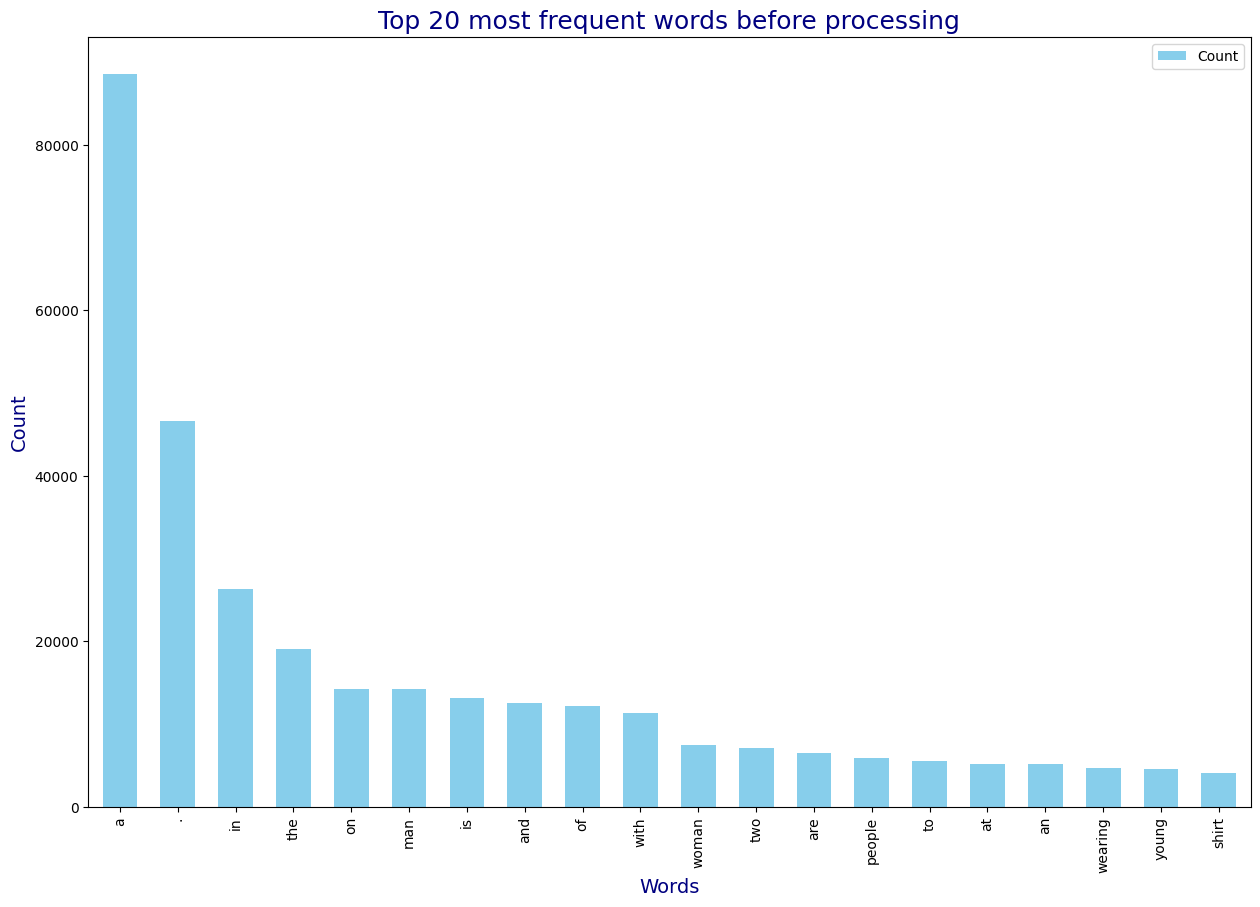

In [ ]:
#Visualise the top 20 occuring words in the captions
print('No of total words :',len(val_count))
for word, count in val_count.most_common(20):
  print(word, ": ", count)
lst = val_count.most_common(20)
most_common_words_df = pd.DataFrame(lst, columns = ['Word', 'Count'])
most_common_words_df.plot.bar(x='Word', y='Count', width=0.6, color='skyblue', figsize=(15, 10))
plt.title("Top 20 most frequent words before processing", fontsize = 18, color= 'navy')
plt.xlabel("Words", fontsize = 14, color= 'navy')
plt.ylabel("Count", fontsize = 14, color= 'navy')


In [ ]:
def caption_with_img_plot(image_id, frame) :
  capt = ("\n" *2).join(frame[frame['ID'] == image_id].Caption.to_list())
  fig, ax = plt.subplots()
  ax.set_axis_off()
  idx = pd.DataFrame.ID.to_list().index(image_id)
  im =  Image.open(pd.DataFrame.Path.iloc[idx])
  w, h = im.size[0], im.size[-1]
  ax.imshow(im)
  ax.text(w+50, h, capt, fontsize = 10, color = 'navy')
#caption_with_img_plot(pd.DataFrame.ID.iloc[20000], df_merge)

In [ ]:
#data cleaning
rem_punct = str.maketrans('', '', string.punctuation)
for r in range(len(annotationstotal)) :
  line = annotationstotal[r]
  line = line.split()

  # remove ambiguity
  for word in line:
    if (word!=word.lower()):
      line = [word.lower() for word in line]

  # remove punctuation from each caption and hanging letters
  line = [word.translate(rem_punct) for word in line]
  line = [word for word in line if len(word) > 0]

  # remove numeric values
  line = [word for word in line if word.isalpha()]

  annotationstotal[r] = ' '.join(line)

#add the <start> & <end> token to all those captions as well
annotations = ['<start>' + ' ' + line + ' ' + '<end>' for line in annotationstotal]

#Create a list which contains all the path to the images
all_img_path = all_img_vector
##list contatining captions for an image
annotations[0:5]


['<start> a woman in a red backpack stands in a valley looking out at the mountains <end>',
 '<start> a dog chases a ball <end>',
 '<start> two women are looking at a bunch of bicycles <end>',
 '<start> an elderly man with his navy pants rolled up to his knees harvests herbs from a garden <end>',
 '<start> a child shows off their snow shovel <end>']

In [ ]:
import math
res=0
word_counts ={}
threshold = 2
for line in annotationstotal:
  for word in line.split():
    word_counts[word] = word_counts.get(word, 0) + 1

print(word_counts)

for i in range(len(annotationstotal)):
  #print(type(len(annotations[i].split())))
  res = res + len(annotationstotal[i].split())
res=res-len(annotationstotal)*2
#print ("The number of words in string are : " + str(res))
vocabulary = [word for line in annotationstotal for word in line.split() if word_counts[word] >= threshold]
val_count = Counter(vocabulary)
unq = len(val_count)-2
print("No of total unique words in vocabulary after data cleaning excluding <start> and <end>:",unq)

{'a': 88594, 'woman': 7453, 'in': 26378, 'red': 2972, 'backpack': 178, 'stands': 869, 'valley': 15, 'looking': 1541, 'out': 1040, 'at': 5227, 'the': 19094, 'mountains': 147, 'dog': 3098, 'chases': 48, 'ball': 1208, 'two': 7137, 'women': 1752, 'are': 6472, 'bunch': 99, 'of': 12231, 'bicycles': 90, 'an': 5211, 'elderly': 356, 'man': 14302, 'with': 11328, 'his': 3644, 'navy': 43, 'pants': 526, 'rolled': 21, 'up': 1641, 'to': 5549, 'knees': 30, 'harvests': 3, 'herbs': 4, 'from': 1182, 'garden': 76, 'child': 1702, 'shows': 85, 'off': 688, 'their': 1267, 'snow': 781, 'shovel': 66, 'five': 274, 'people': 5940, 'standing': 2836, 'on': 14306, 'stage': 452, 'mountain': 336, 'bike': 799, 'is': 13176, 'pedaling': 6, 'hill': 257, 'soldering': 8, 'piece': 223, 'metal': 202, 'as': 1493, 'watches': 298, 'workers': 405, 'enjoy': 63, 'moment': 18, 'levity': 1, 'while': 3332, 'truck': 247, 'boy': 3307, 'renaissance': 11, 'fair': 61, 'costume': 190, 'by': 1796, 'cars': 91, 'parked': 96, 'grass': 843, 'new

In [ ]:
# Creating tokenizer
top_word_cnt = unq
tokenizer = Tokenizer(num_words = top_word_cnt+1, filters= '!"#$%^&*()_+.,:;-?/~`{}[]|\=@ ',
                      lower = True, char_level = False,
                      oov_token = 'UNK')

# Creating word-to-index and index-to-word mappings.
tokenizer.fit_on_texts(annotations)
#transform each text into a sequence of integers
train_seqs = tokenizer.texts_to_sequences(annotations)

# Add PAD token for zero
tokenizer.word_index['PAD'] = 0
tokenizer.index_word[0] = 'PAD'
print(tokenizer.oov_token)
print(tokenizer.index_word[0])

UNK
PAD


In [ ]:
# Creating a word count for our tokenizer to visualize the Top 20 occuring words after text processing

tokenizer_top_words = [word for line in annotationstotal for word in line.split() ]

#tokenizer_top_words_count
tokenizer_top_words_count = collections.Counter(tokenizer_top_words)

for word, count in tokenizer_top_words_count.most_common(20) :
  print(word, ": ", count)

tokens = tokenizer_top_words_count.most_common(20)
most_com_words_df = pd.DataFrame(tokens, columns = ['Word', 'Count'])

a :  88594
in :  26378
the :  19094
on :  14306
man :  14302
is :  13176
and :  12588
of :  12231
with :  11328
woman :  7453
two :  7137
are :  6472
people :  5940
to :  5549
at :  5227
an :  5211
wearing :  4742
young :  4601
shirt :  4055
white :  3940


Text(0, 0.5, 'Counts')

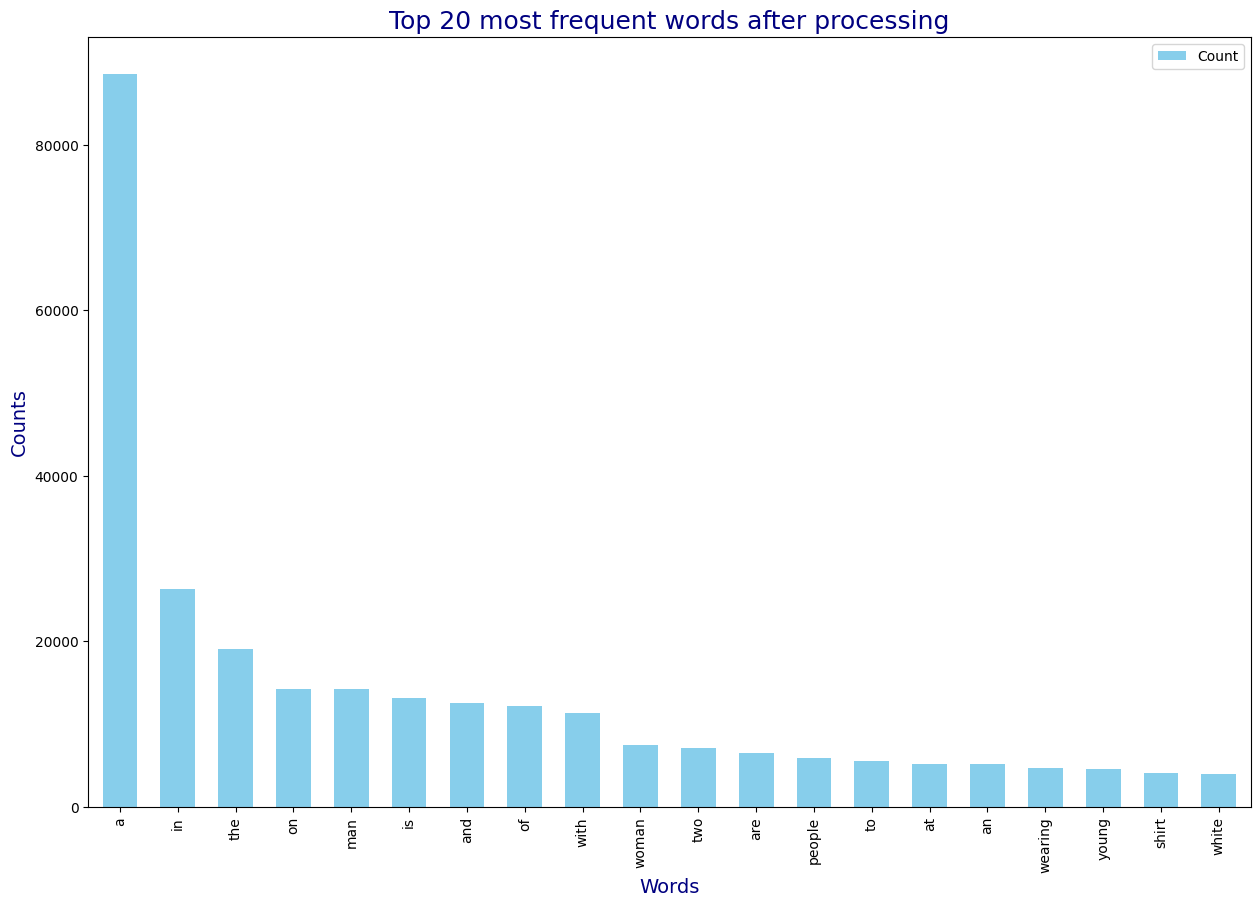

In [ ]:
#plot 20 most common occuring words after processing

lst2=tokenizer_top_words_count.most_common(20)
most_common_words_df=pd.DataFrame(lst2, columns = ['Word','Count'])
most_common_words_df.plot.bar(x = 'Word', y= 'Count', width=0.6, color = 'skyblue', figsize = (15, 10))
plt.title('Top 20 most frequent words after processing', fontsize =18, color= 'navy')
plt.xlabel('Words', fontsize =14, color= 'navy')
plt.ylabel('Counts', fontsize =14, color= 'navy')

In [ ]:
# Pad each vector to the max_length of the captions  store it to a vairable
train_seqs_len = [len(seq) for seq in train_seqs]
longest_sentence_length = max(train_seqs_len)
print(longest_sentence_length)
cap_vector= tf.keras.preprocessing.sequence.pad_sequences(train_seqs, padding= 'post', maxlen = longest_sentence_length,
                                                          dtype='int32', value=0)
print("The shape of Caption vector is :" + str(cap_vector.shape))

# creating list to store preprocessed images and setting up the Image shape
preprocessed_image = []
IMAGE_SHAPE = (256, 256)
#checking image format
#tf.keras.backend.image_data_format()

71
The shape of Caption vector is :(55000, 71)


In [ ]:
# for img in all_imgs[0:5] :
#     img = tf.io.read_file(img, name=None)
#     img = tf.image.decode_jpeg(img, channels=0)
#     img = tf.image.resize(img, (256, 256))
#     img = vit.preprocess_inputs(img)
#     preprocessed_image.append(img)

# # checking first five images post preprocessing
# Display_Images = preprocessed_image[0:5]
# figure, axes = plt.subplots(1,5)
# figure.set_figwidth(20)
# for ax, image in zip(axes, Display_Images) :
#   print('Shape after resize : ', image.shape)
#   ax.imshow(image)
#   #ax.grid('off')


In [ ]:
def load_images(image_path) :
  img = tf.io.read_file(image_path, name = None)
  img = tf.image.decode_jpeg(img, channels=3)
  img = tf.image.resize(img, IMAGE_SHAPE)
  img = vit.preprocess_inputs(img)
  return img, image_path

# Map each image full path to the function, to preprocess the image
training_list = sorted(set(all_img_vector))
New_Img = tf.data.Dataset.from_tensor_slices(training_list)
New_Img = New_Img.map(load_images, num_parallel_calls = tf.data.experimental.AUTOTUNE)
New_Img = New_Img.batch(32, drop_remainder=False)

#Ratio = 80:10:10
# path_train,  caption_train = all_img_vectort, cap_vector[:40000]#train_test_split(all_img_vectortotal, cap_vector, test_size = 0.10, random_state = 42)
# path_val, caption_val = all_img_vectorv[:2000], cap_vector[-4000:-2000]#train_test_split(path_train, caption_train, test_size=0.12, random_state=42)
# # Define test set seperately
# path_test, caption_test = all_img_vectorv[2000:], cap_vector[-2000:]


# path_train,  caption_train = all_img_vectort, cap_vector[:40000]        # 148915
# path_val, caption_val = all_img_vectorv, cap_vector[40000:45000]        # 148915:153915
# path_test, caption_test = all_img_vectortst, cap_vector[45000:]         # 153915:


path_train,  caption_train = all_img_vectort, cap_vector[:50000]
path_val, caption_val = all_img_vectorv, cap_vector[50000:]
#path_test, caption_test = all_img_vectortst, cap_vector[45000:]

In [ ]:
print("Training data for images: " + str(len(path_train)))
print("Validation data for images: " + str(len(path_val)))
#print("Testing data for images: " + str(len(path_test)))
print("Training data for Captions: " + str(len(caption_train)))
print("Validation data for Captions: " + str(len(caption_val)))
#print("Testing data for Captions: " + str(len(caption_test)))
#print(path_test)

Training data for images: 50000
Validation data for images: 5000
Training data for Captions: 50000
Validation data for Captions: 5000


In [ ]:
!pip install vit-keras

import vit_keras
from vit_keras import vit
import tensorflow as tf
from tqdm.notebook import tqdm
import numpy as np


In [ ]:
vit_model = vit.vit_b16(
        image_size = IMAGE_SHAPE,
        activation = 'softmax',
        pretrained = True,
        include_top = False,
        pretrained_top = False,
        # weights = 'imagenet21k'
        )

new_input =vit_model.input
hidden_layer = vit_model.layers[-2].output
image_features_extract_model = tf.keras.Model(new_input, hidden_layer)

for layer in image_features_extract_model.layers:
  layer.trainable = False
#image_features_extract_model.summary()

img_features = {}
for image,image_path in tqdm(New_Img):
  batch_features = image_features_extract_model(image)
  #print("Batch Features Shape:", batch_features.shape)
  #batch_features_flattened = tf.reshape(batch_features, (batch_features.shape[0], -1))
  for batch_feat, path in zip(batch_features, image_path) :
    feature_path = path.numpy().decode('utf-8')
    img_features[feature_path] = batch_feat.numpy()

  0%|          | 0/344 [00:00<?, ?it/s]

In [ ]:
image_features_extract_model.summary()

Model: "model_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_2 (InputLayer)        [(None, 256, 256, 3)]     0         
                                                                 
 embedding (Conv2D)          (None, 16, 16, 1024)      787456    
                                                                 
 reshape_1 (Reshape)         (None, 256, 1024)         0         
                                                                 
 class_token (ClassToken)    (None, 257, 1024)         1024      
                                                                 
 Transformer/posembed_input  (None, 257, 1024)         263168    
  (AddPositionEmbs)                                              
                                                                 
 Transformer/encoderblock_0  ((None, 257, 1024),       12596224  
  (TransformerBlock)          (None, 16, None, None)       

In [ ]:
batch_feat.shape

TensorShape([257, 768])

In [ ]:
#func to provide, both images along with the captions as input
def map(image_name, caption):
    img_tensor = img_features[image_name.decode('utf-8')]
    return img_tensor, caption

#func to transform the created dataset(img_path,cap) to (features,cap) using the map_func created earlier
BUFFER_SIZE = 1000
BATCH_SIZE = 32
def gen_dataset(img, capt):

    data = tf.data.Dataset.from_tensor_slices((img, capt))
    data = data.map(lambda ele1, ele2 : tf.numpy_function(map, [ele1, ele2], [tf.float32, tf.int32]),
                    num_parallel_calls = tf.data.experimental.AUTOTUNE)


    data = (data.shuffle(BUFFER_SIZE, reshuffle_each_iteration= True).batch(BATCH_SIZE, drop_remainder = False)
    .prefetch(tf.data.experimental.AUTOTUNE))
    return data

train_dataset = gen_dataset(path_train,caption_train)
val_dataset = gen_dataset(path_val,caption_val)
#test_dataset = gen_dataset(path_test,caption_test)

sample_img_batch, sample_cap_batch = next(iter(train_dataset))
print(sample_img_batch.shape)  #(batch_size, 8*8, 2048)
print(sample_cap_batch.shape) #(batch_size,max_len)


#Setting  parameters
embedding_dim = 256
units = 512

#top 60% words +1
vocab_size = top_word_cnt+1
train_num_steps = len(path_train) // BATCH_SIZE
val_num_steps = len(path_val) // BATCH_SIZE
#test_num_steps = len(path_test) // BATCH_SIZE

max_length = longest_sentence_length  #31
feature_shape = batch_feat.shape[1]
attention_feature_shape = batch_feat.shape[0]

(32, 257, 768)
(32, 71)


In [ ]:
class Encoder(Model):
    def __init__(self,embed_dim):
        super(Encoder, self).__init__()
        self.dense = tf.keras.layers.Dense(embed_dim)

    def call(self, features):
        features =  self.dense(features) # extract the features from the image shape: (batch, 8*8, embed_dim)
        features =  tf.keras.activations.relu(features, alpha=0.01, max_value=None, threshold=0)
        return features

class Attention(Model):
    def __init__(self, units):
        super(Attention, self).__init__()
        self.q = tf.keras.layers.Dense(units)
        self.k = tf.keras.layers.Dense(units)
        self.V = tf.keras.layers.Dense(1)
        self.units=units

    def call(self, features, hidden):
        hidden_with_time_axis = hidden[:, tf.newaxis]
        score = tf.keras.activations.tanh(self.q(features) + self.k(hidden_with_time_axis))
        attention_weights = tf.keras.activations.softmax(self.V(score), axis=1)
        context_vector = attention_weights * features
        context_vector = tf.reduce_sum(context_vector, axis=1)
        return context_vector, attention_weights

class Decoder(Model):
    def __init__(self, embed_dim, units, vocab_size):
        super(Decoder, self).__init__()
        self.units=units
        self.attention = Attention(self.units) #iniitalize Attention model by units
        self.embed = tf.keras.layers.Embedding(vocab_size, embed_dim) #building Embedding layer
        self.gru = tf.keras.layers.GRU(self.units,return_sequences=True,return_state=True,recurrent_initializer='glorot_uniform')
        self.d1 = tf.keras.layers.Dense(self.units) #build your Dense layer
        self.d2 = tf.keras.layers.Dense(vocab_size) #build your Dense layer


    def call(self,x,features, hidden):
        context_vector, attention_weights = self.attention(features, hidden) #create your context vector & attention weights from attention model
        embed = self.embed(x) # embed your input to shape: (batch_size, 1, embedding_dim)
        embed = tf.concat([tf.expand_dims(context_vector, 1), embed], axis = -1) # Concatenate your input with the context vector from attention layer. Shape: (batch_size, 1, embedding_dim + embedding_dim)
        output,state = self.gru(embed) # Extract the output & hidden state from GRU layer. Output shape : (batch_size, max_length, hidden_size)
        output = self.d1(output)
        output = tf.reshape(output, (-1, output.shape[2])) # shape : (batch_size * max_length, hidden_size)
        output = self.d2(output) # shape : (batch_size * max_length, vocab_size)

        return output, state, attention_weights

    def init_state(self, batch_size):
        return tf.zeros((batch_size, self.units))

In [ ]:
encoder=Encoder(embedding_dim)
decoder=Decoder(embedding_dim, units, vocab_size)
features=encoder(sample_img_batch)
hidden = decoder.init_state(batch_size=sample_cap_batch.shape[0])
dec_input = tf.expand_dims([tokenizer.word_index['<start>']] * sample_cap_batch.shape[0], 1)

predictions, hidden_out, attention_weights= decoder(dec_input, features, hidden)
print('Feature shape from Encoder: {}'.format(features.shape)) #(batch, 8*8, embed_dim)
print('Predcitions shape from Decoder: {}'.format(predictions.shape)) #(batch_size,vocab_size)
print('Attention weights shape: {}'.format(attention_weights.shape)) #(batch_size,257, embed_dim)

Feature shape from Encoder: (32, 257, 256)
Predcitions shape from Decoder: (32, 7590)
Attention weights shape: (32, 257, 1)


In [ ]:
optimizer = tf.keras.optimizers.Nadam(learning_rate = 0.001)  #defining the optimizer
loss_object = tf.keras.losses.SparseCategoricalCrossentropy(from_logits = True, reduction = tf.keras.losses.Reduction.NONE) #define your loss object
#loss_object = tf.keras.losses.CategoricalCrossentropy(from_logits = True, reduction = tf.keras.losses.Reduction.NONE) #define your loss object


def loss_function(real, pred):
    mask = tf.math.logical_not(tf.math.equal(real, 0))
    loss_ = loss_object(real, pred)

    mask = tf.cast(mask, dtype=loss_.dtype)
    loss_ *= mask
    return tf.reduce_mean(loss_)

checkpoint_path = "/content/checkpoint"
ckpt = tf.train.Checkpoint(encoder=encoder,
                           decoder=decoder,
                           optimizer = optimizer)
ckpt_manager = tf.train.CheckpointManager(ckpt, checkpoint_path, max_to_keep=5)

start_epoch = 0
if ckpt_manager.latest_checkpoint:
    start_epoch = int(ckpt_manager.latest_checkpoint.split('-')[-1])


@tf.function
def train_step(img_tensor, target):
    loss = 0
    hidden = decoder.init_state(batch_size=target.shape[0])
    dec_input = tf.expand_dims([tokenizer.word_index['<start>']] * target.shape[0], 1)

    with tf.GradientTape() as tape:

        encoder_op = encoder(img_tensor)
        for r in range(1, target.shape[1]) :
          predictions, hidden, _ = decoder(dec_input, encoder_op, hidden)
          loss = loss + loss_function(target[:, r], predictions)
          dec_input = tf.expand_dims(target[:, r], 1)

    avg_loss = (loss/ int(target.shape[1])) #avg loss per batch
    trainable_vars = encoder.trainable_variables + decoder.trainable_variables
    grad = tape.gradient (loss, trainable_vars)
    optimizer.apply_gradients(zip(grad, trainable_vars))

    return loss, avg_loss


@tf.function
def val_step(img_tensor, target):
    loss = 0
    hidden = decoder.init_state(batch_size = target.shape[0])
    dec_input = tf.expand_dims([tokenizer.word_index['<start>']] * target.shape[0], 1)
    with tf.GradientTape() as tape:
      encoder_op = encoder(img_tensor)
      for r in range(1, target.shape[1]) :
        predictions, hidden, _ = decoder(dec_input, encoder_op, hidden)
        loss = loss + loss_function(target[:, r], predictions)
        dec_input = tf.expand_dims(target[: , r], 1)
    avg_loss = (loss/ int(target.shape[1])) #avg loss per batch
    trainable_vars = encoder.trainable_variables + decoder.trainable_variables
    grad = tape.gradient (loss, trainable_vars)
    optimizer.apply_gradients(zip(grad, trainable_vars))
    return loss, avg_loss

def val_loss_cal(val_dataset):
    total_loss = 0
    for (batch, (img_tensor, target)) in enumerate(val_dataset) :
      batch_loss, t_loss = val_step(img_tensor, target)
      total_loss = total_loss + t_loss
      avg_val_loss = total_loss/ val_num_steps

    return avg_val_loss

In [ ]:
train_loss_plot = []
val_loss_plot = []
#test_loss_plot = []
EPOCHS = 30
best_val_loss=100
#best_test_loss=100
for epoch in tqdm(range(0, EPOCHS)):
    start = time.time()
    total_loss = 0
    for (batch, (img_tensor, target)) in enumerate(train_dataset):
        batch_loss, t_loss = train_step(img_tensor, target)
        total_loss += t_loss
        avg_train_loss=total_loss / train_num_steps
    train_loss_plot.append(avg_train_loss)
    val_loss=val_loss_cal(val_dataset)
    val_loss_plot.append(val_loss)
#   test_loss = test_loss_cal(test_dataset)
#   test_loss_plot.append(test_loss)
    print ('For epoch: {}, the train loss is {:.3f}, validation loss is {:.3f}'.format(epoch+1,avg_train_loss, val_loss))
#    print ('Time taken for 1 epoch {} sec\n'.format(time.time() - start))

    if val_loss < best_val_loss:
        #print('Validation loss has been reduced from %.3f to %.3f' % (best_val_loss, val_loss))
        best_val_loss = val_loss
        ckpt_manager.save()


  0%|          | 0/30 [00:00<?, ?it/s]

For epoch: 1, the train loss is 0.652, validation loss is 0.569
For epoch: 2, the train loss is 0.528, validation loss is 0.505
For epoch: 3, the train loss is 0.479, validation loss is 0.464
For epoch: 4, the train loss is 0.444, validation loss is 0.436
For epoch: 5, the train loss is 0.413, validation loss is 0.409
For epoch: 6, the train loss is 0.386, validation loss is 0.386
For epoch: 7, the train loss is 0.363, validation loss is 0.366
For epoch: 8, the train loss is 0.343, validation loss is 0.350
For epoch: 9, the train loss is 0.324, validation loss is 0.334
For epoch: 10, the train loss is 0.309, validation loss is 0.321
For epoch: 11, the train loss is 0.295, validation loss is 0.310
For epoch: 12, the train loss is 0.282, validation loss is 0.300
For epoch: 13, the train loss is 0.271, validation loss is 0.291
For epoch: 14, the train loss is 0.262, validation loss is 0.283
For epoch: 15, the train loss is 0.254, validation loss is 0.276
For epoch: 16, the train loss is 0

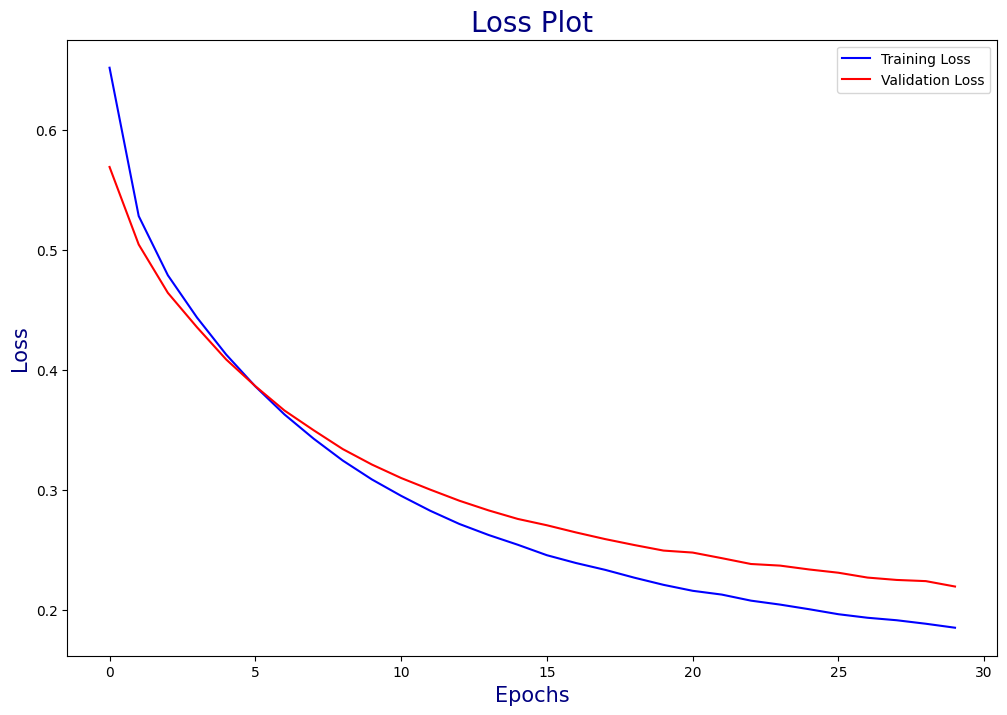

In [ ]:
from matplotlib.pyplot import figure
figure(figsize=(12, 8))
plt.plot(train_loss_plot, color='blue', label = 'Training Loss')
plt.plot(val_loss_plot, color='red', label ='Validation Loss')
#plt.plot(test_loss_plot, color='red', label = 'Test Loss')
plt.xlabel('Epochs', fontsize = 15, color = 'navy')
plt.ylabel('Loss', fontsize = 15, color = 'navy')
plt.title('Loss Plot', fontsize = 20, color = 'navy')
plt.legend()
plt.show()

In [ ]:
import openpyxl

def save_loss_to_excel(train_loss, val_loss, file_path):
    wb = openpyxl.Workbook()
    sheet = wb.active
    sheet.title = "Loss Data"

    # Write headers
    sheet["A1"] = "Iteration"
    sheet["B1"] = "Train Loss"
    sheet["C1"] = "Validation Loss"
    #sheet["D1"] = "Test Loss"
    # Write data
    for i, (train_loss_val, val_loss_val) in enumerate(zip(train_loss_plot, val_loss_plot), start=3):
        sheet[f"A{i}"] = i - 1  # Iteration number
        sheet[f"B{i}"] = train_loss_val.numpy()
        #sheet[f"B{i}"] = train_loss_val
        sheet[f"C{i}"] = val_loss_val.numpy()
        #sheet[f"D{i}"] = test_loss_val.numpy()

    # Save to Excel file
    wb.save(file_path)
    print(f"Loss data saved to {file_path}")

# Example usage
train_loss = train_loss_plot
val_loss = val_loss_plot
#test_loss = test_loss_plot
save_loss_to_excel(train_loss, val_loss, "lossdata_VitAttGRU26.xlsx")


Loss data saved to lossdata_VitAttGRU26.xlsx


In [ ]:
def evaluate(image):
    attention_plot = np.zeros((max_length, attention_feature_shape))

    hidden = decoder.init_state(batch_size=1)

    temp_input = tf.expand_dims(load_images(image)[0], 0)
    img_tensor_val = image_features_extract_model(temp_input)
    #img_tensor_val = tf.reshape(img_tensor_val, (img_tensor_val.shape[0], -1))

    features = encoder (img_tensor_val)

    dec_input = tf.expand_dims([tokenizer.word_index['<start>']], 0)
    result = []

    for i in range(max_length):
        predictions, hidden, attention_weights = decoder(dec_input, features, hidden)
        attention_plot[i] = tf.reshape(attention_weights, (-1, )).numpy()

        predicted_id = tf.argmax(predictions[0]).numpy()
        result.append (tokenizer.index_word[predicted_id])

        if tokenizer.index_word[predicted_id] == '<end>':
            return result, attention_plot,predictions

        dec_input = tf.expand_dims([predicted_id], 0)

    attention_plot = attention_plot[:len(result), :]
    return result, attention_plot,predictions


def plot_attention_map(result, attention_plot, test_image):
    temp_image = np.array(Image.open(test_image))

    fig = plt.figure(figsize=(20, 20))

    len_result = len(result)

    for l in range(len_result):
        temp_att = np.resize(attention_plot[l], (9, 9))
        ax = fig.add_subplot(len_result//2, len_result//2, l+1)
        ax.set_title(result[l])
        img = ax.imshow(temp_image)
        ax.imshow(temp_att, cmap='gray', alpha=0.6, extent=img.get_extent())

    plt.tight_layout()
    plt.show()

def filt_text(text):
    filt=['<start>','<unk>','<end>']
    temp= text.split()
    [temp.remove(j) for k in filt for j in temp if k==j]
    text=' '.join(temp)
    return text
#image_test = path_test.copy()
#image_val=path_val.copy()
image_test = path_val.copy()

Real Caption: two girls smile at one another as the loud crowd carries on with the festivities
Prediction Caption: a crowd of people are clapping


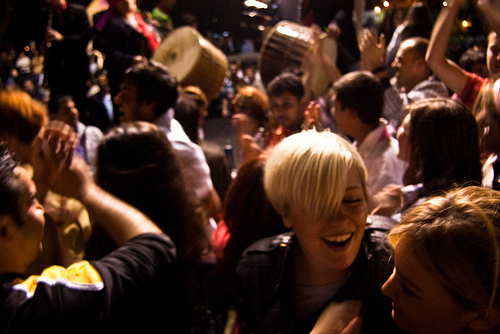

In [ ]:
def predicted_captiontest(rndm, autoplay=False) :

    cap_test_data = caption_val.copy()
    rid = 100
    # rid = random.sample(range(0, rndm),2)
    real_cap_list=[]
    pred_cap_list=[]
    j=rid
    test_image=image_test[j]
    #print(len(cap_test_data))
    real_caption = ' '.join([tokenizer.index_word[i] for i in cap_test_data[j] if i not in [0]])
    #print(real_caption)
    result, attention_plot, pred_test = evaluate(test_image)
    real_caption=filt_text(real_caption)
    pred_caption=' '.join(result).rsplit(' ', 1)[0]
    real_appn = []
    real_appn.append(real_caption.split())
    real_cap_list.append(real_appn)
    pred_cap_list.append(pred_caption.split())

    #all_eval_method(test_image,real_cap_list, pred_cap_list)

    print ('Real Caption:', real_caption)
    print ('Prediction Caption:', pred_caption)
   # plot_attention_map(result, attention_plot, test_image)
    speech = gTTS('Predicted Caption : ' + pred_caption, lang = 'en', slow = False)
    speech.save('voice.mp3')
    audio_file = 'voice.mp3'

    display.display(display.Audio(audio_file, rate = None, autoplay = autoplay))

    return test_image

test_image = predicted_captiontest(len(image_test), True)
Image.open(test_image)

Real Caption: an old man is sitting on a sidewalk in front of a pile of folded blankets
Prediction Caption: a man is sitting on the ground in front of a bunch of woven blankets


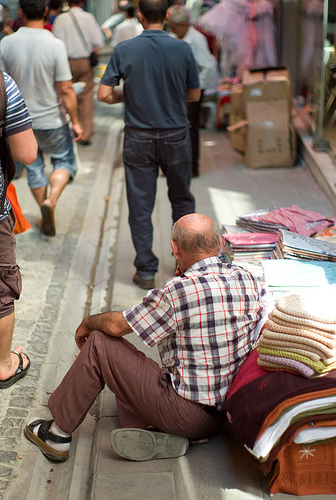

In [ ]:
def predicted_captiontest(rndm, autoplay=False) :

    cap_test_data = caption_val.copy()
    rid = 500
    # rid = random.sample(range(0, rndm),2)
    real_cap_list=[]
    pred_cap_list=[]
    j=rid
    test_image=image_test[j]
    #print(len(cap_test_data))
    real_caption = ' '.join([tokenizer.index_word[i] for i in cap_test_data[j] if i not in [0]])
    #print(real_caption)
    result, attention_plot, pred_test = evaluate(test_image)
    real_caption=filt_text(real_caption)
    pred_caption=' '.join(result).rsplit(' ', 1)[0]
    real_appn = []
    real_appn.append(real_caption.split())
    real_cap_list.append(real_appn)
    pred_cap_list.append(pred_caption.split())

    #all_eval_method(test_image,real_cap_list, pred_cap_list)

    print ('Real Caption:', real_caption)
    print ('Prediction Caption:', pred_caption)
   # plot_attention_map(result, attention_plot, test_image)
    speech = gTTS('Predicted Caption : ' + pred_caption, lang = 'en', slow = False)
    speech.save('voice.mp3')
    audio_file = 'voice.mp3'

    display.display(display.Audio(audio_file, rate = None, autoplay = autoplay))

    return test_image

test_image = predicted_captiontest(len(image_test), True)
Image.open(test_image)

Real Caption: two women wearing skirts dance on a stage
Prediction Caption: two dancers in gypsy garb practicing a dance


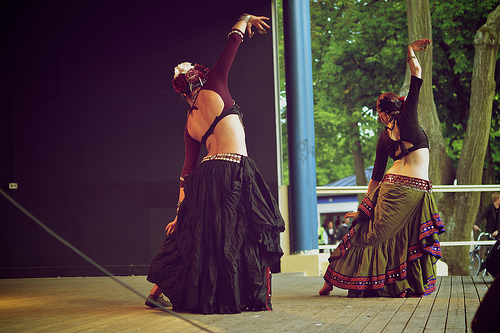

In [ ]:
def predicted_captiontest(rndm, autoplay=False) :

    cap_test_data = caption_val.copy()
    rid = 1000
    # rid = random.sample(range(0, rndm),2)
    real_cap_list=[]
    pred_cap_list=[]
    j=rid
    test_image=image_test[j]
    #print(len(cap_test_data))
    real_caption = ' '.join([tokenizer.index_word[i] for i in cap_test_data[j] if i not in [0]])
    #print(real_caption)
    result, attention_plot, pred_test = evaluate(test_image)
    real_caption=filt_text(real_caption)
    pred_caption=' '.join(result).rsplit(' ', 1)[0]
    real_appn = []
    real_appn.append(real_caption.split())
    real_cap_list.append(real_appn)
    pred_cap_list.append(pred_caption.split())

    #all_eval_method(test_image,real_cap_list, pred_cap_list)

    print ('Real Caption:', real_caption)
    print ('Prediction Caption:', pred_caption)
   # plot_attention_map(result, attention_plot, test_image)
    speech = gTTS('Predicted Caption : ' + pred_caption, lang = 'en', slow = False)
    speech.save('voice.mp3')
    audio_file = 'voice.mp3'

    display.display(display.Audio(audio_file, rate = None, autoplay = autoplay))

    return test_image

test_image = predicted_captiontest(len(image_test), True)
Image.open(test_image)

Real Caption: three women dressed in plain clothes are cooking a meal in their kitchen
Prediction Caption: three women in a kitchen


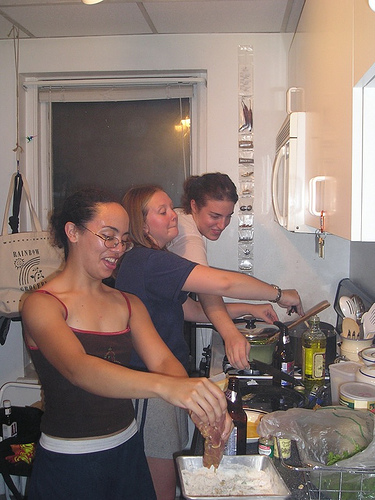

In [ ]:
def predicted_captiontest(rndm, autoplay=False) :

    cap_test_data = caption_val.copy()
    rid = 1400
    # rid = random.sample(range(0, rndm),2)
    real_cap_list=[]
    pred_cap_list=[]
    j=rid
    test_image=image_test[j]
    #print(len(cap_test_data))
    real_caption = ' '.join([tokenizer.index_word[i] for i in cap_test_data[j] if i not in [0]])
    #print(real_caption)
    result, attention_plot, pred_test = evaluate(test_image)
    real_caption=filt_text(real_caption)
    pred_caption=' '.join(result).rsplit(' ', 1)[0]
    real_appn = []
    real_appn.append(real_caption.split())
    real_cap_list.append(real_appn)
    pred_cap_list.append(pred_caption.split())

    #all_eval_method(test_image,real_cap_list, pred_cap_list)

    print ('Real Caption:', real_caption)
    print ('Prediction Caption:', pred_caption)
   # plot_attention_map(result, attention_plot, test_image)
    speech = gTTS('Predicted Caption : ' + pred_caption, lang = 'en', slow = False)
    speech.save('voice.mp3')
    audio_file = 'voice.mp3'

    display.display(display.Audio(audio_file, rate = None, autoplay = autoplay))

    return test_image

test_image = predicted_captiontest(len(image_test), True)
Image.open(test_image)

Real Caption: a woman in yellow
Prediction Caption: a woman in sunglasses and a yellow shirt is facing forward


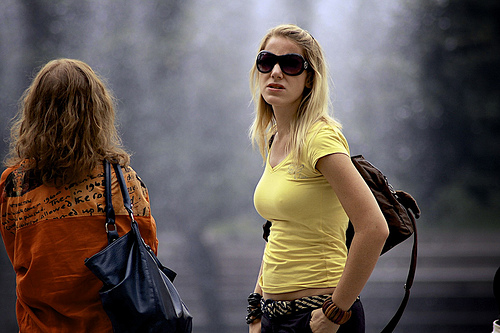

In [ ]:
def predicted_captiontest(rndm, autoplay=False) :

    cap_test_data = caption_val.copy()
    rid = 2100
    # rid = random.sample(range(0, rndm),2)
    real_cap_list=[]
    pred_cap_list=[]
    j=rid
    test_image=image_test[j]
    #print(len(cap_test_data))
    real_caption = ' '.join([tokenizer.index_word[i] for i in cap_test_data[j] if i not in [0]])
    #print(real_caption)
    result, attention_plot, pred_test = evaluate(test_image)
    real_caption=filt_text(real_caption)
    pred_caption=' '.join(result).rsplit(' ', 1)[0]
    real_appn = []
    real_appn.append(real_caption.split())
    real_cap_list.append(real_appn)
    pred_cap_list.append(pred_caption.split())

    #all_eval_method(test_image,real_cap_list, pred_cap_list)

    print ('Real Caption:', real_caption)
    print ('Prediction Caption:', pred_caption)
   # plot_attention_map(result, attention_plot, test_image)
    speech = gTTS('Predicted Caption : ' + pred_caption, lang = 'en', slow = False)
    speech.save('voice.mp3')
    audio_file = 'voice.mp3'

    display.display(display.Audio(audio_file, rate = None, autoplay = autoplay))

    return test_image

test_image = predicted_captiontest(len(image_test), True)
Image.open(test_image)

Real Caption: two young girls and an old man with gray hair and beard are opening christmas presents
Prediction Caption: a family at christmas presents


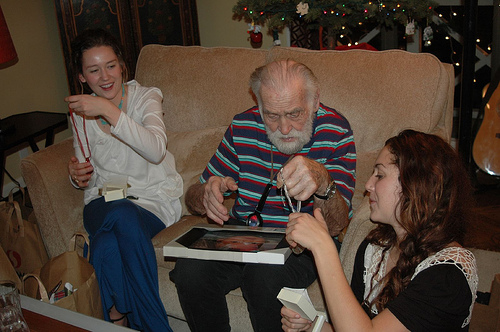

In [ ]:
def predicted_captiontest(rndm, autoplay=False) :

    cap_test_data = caption_val.copy()
    rid = 3500
    # rid = random.sample(range(0, rndm),2)
    real_cap_list=[]
    pred_cap_list=[]
    j=rid
    test_image=image_test[j]
    #print(len(cap_test_data))
    real_caption = ' '.join([tokenizer.index_word[i] for i in cap_test_data[j] if i not in [0]])
    #print(real_caption)
    result, attention_plot, pred_test = evaluate(test_image)
    real_caption=filt_text(real_caption)
    pred_caption=' '.join(result).rsplit(' ', 1)[0]
    real_appn = []
    real_appn.append(real_caption.split())
    real_cap_list.append(real_appn)
    pred_cap_list.append(pred_caption.split())

    #all_eval_method(test_image,real_cap_list, pred_cap_list)

    print ('Real Caption:', real_caption)
    print ('Prediction Caption:', pred_caption)
   # plot_attention_map(result, attention_plot, test_image)
    speech = gTTS('Predicted Caption : ' + pred_caption, lang = 'en', slow = False)
    speech.save('voice.mp3')
    audio_file = 'voice.mp3'

    display.display(display.Audio(audio_file, rate = None, autoplay = autoplay))

    return test_image

test_image = predicted_captiontest(len(image_test), True)
Image.open(test_image)

Real Caption: two young girls and an old man with gray hair and beard are opening christmas presents
Prediction Caption: a family at christmas presents


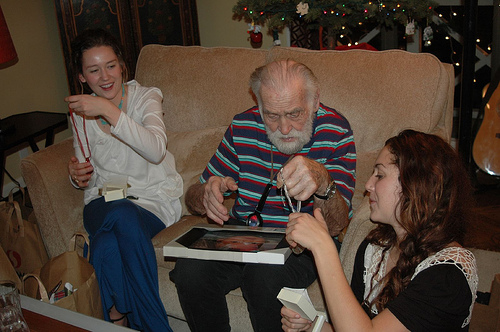

In [ ]:
def predicted_captiontest(rndm, autoplay=False) :

    cap_test_data = caption_val.copy()
    rid = 3500
    # rid = random.sample(range(0, rndm),2)
    real_cap_list=[]
    pred_cap_list=[]
    j=rid
    test_image=image_test[j]
    #print(len(cap_test_data))
    real_caption = ' '.join([tokenizer.index_word[i] for i in cap_test_data[j] if i not in [0]])
    #print(real_caption)
    result, attention_plot, pred_test = evaluate(test_image)
    real_caption=filt_text(real_caption)
    pred_caption=' '.join(result).rsplit(' ', 1)[0]
    real_appn = []
    real_appn.append(real_caption.split())
    real_cap_list.append(real_appn)
    pred_cap_list.append(pred_caption.split())

    #all_eval_method(test_image,real_cap_list, pred_cap_list)

    print ('Real Caption:', real_caption)
    print ('Prediction Caption:', pred_caption)
   # plot_attention_map(result, attention_plot, test_image)
    speech = gTTS('Predicted Caption : ' + pred_caption, lang = 'en', slow = False)
    speech.save('voice.mp3')
    audio_file = 'voice.mp3'

    display.display(display.Audio(audio_file, rate = None, autoplay = autoplay))

    return test_image

test_image = predicted_captiontest(len(image_test), True)
Image.open(test_image)

Real Caption: four young men stare at a young woman wearing a short skirt
Prediction Caption: several people are watching a woman dressed in a white top


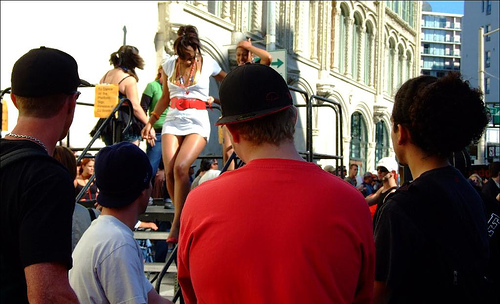

In [ ]:
def predicted_captiontest(rndm, autoplay=False) :

    cap_test_data = caption_val.copy()
    rid = 4000
    # rid = random.sample(range(0, rndm),2)
    real_cap_list=[]
    pred_cap_list=[]
    j=rid
    test_image=image_test[j]
    #print(len(cap_test_data))
    real_caption = ' '.join([tokenizer.index_word[i] for i in cap_test_data[j] if i not in [0]])
    #print(real_caption)
    result, attention_plot, pred_test = evaluate(test_image)
    real_caption=filt_text(real_caption)
    pred_caption=' '.join(result).rsplit(' ', 1)[0]
    real_appn = []
    real_appn.append(real_caption.split())
    real_cap_list.append(real_appn)
    pred_cap_list.append(pred_caption.split())

    #all_eval_method(test_image,real_cap_list, pred_cap_list)

    print ('Real Caption:', real_caption)
    print ('Prediction Caption:', pred_caption)
   # plot_attention_map(result, attention_plot, test_image)
    speech = gTTS('Predicted Caption : ' + pred_caption, lang = 'en', slow = False)
    speech.save('voice.mp3')
    audio_file = 'voice.mp3'

    display.display(display.Audio(audio_file, rate = None, autoplay = autoplay))

    return test_image

test_image = predicted_captiontest(len(image_test), True)
Image.open(test_image)

Real Caption: a man with a bucket and a child pointing to some machinery
Prediction Caption: a man and a child pointing to a large yellow metal sculpture


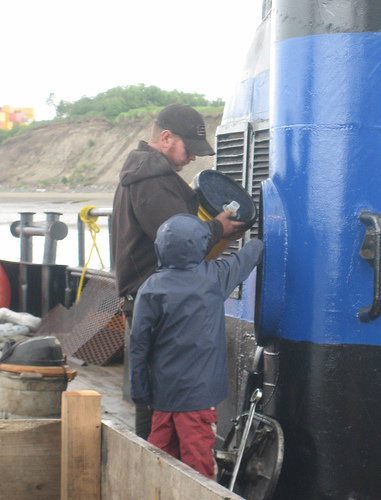

In [ ]:
def predicted_captiontest(rndm, autoplay=False) :

    cap_test_data = caption_val.copy()
    rid = 4500
    # rid = random.sample(range(0, rndm),2)
    real_cap_list=[]
    pred_cap_list=[]
    j=rid
    test_image=image_test[j]
    #print(len(cap_test_data))
    real_caption = ' '.join([tokenizer.index_word[i] for i in cap_test_data[j] if i not in [0]])
    #print(real_caption)
    result, attention_plot, pred_test = evaluate(test_image)
    real_caption=filt_text(real_caption)
    pred_caption=' '.join(result).rsplit(' ', 1)[0]
    real_appn = []
    real_appn.append(real_caption.split())
    real_cap_list.append(real_appn)
    pred_cap_list.append(pred_caption.split())

    #all_eval_method(test_image,real_cap_list, pred_cap_list)

    print ('Real Caption:', real_caption)
    print ('Prediction Caption:', pred_caption)
   # plot_attention_map(result, attention_plot, test_image)
    speech = gTTS('Predicted Caption : ' + pred_caption, lang = 'en', slow = False)
    speech.save('voice.mp3')
    audio_file = 'voice.mp3'

    display.display(display.Audio(audio_file, rate = None, autoplay = autoplay))

    return test_image

test_image = predicted_captiontest(len(image_test), True)
Image.open(test_image)

Real Caption: young laughing boys on a wet vinyl mat
Prediction Caption: two teenage boys in black swim trunks play on a trampoline


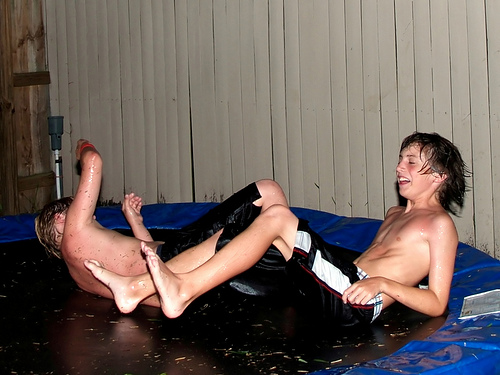

In [ ]:
def predicted_captiontest(rndm, autoplay=False) :

    cap_test_data = caption_val.copy()
    rid = 4400
    # rid = random.sample(range(0, rndm),2)
    real_cap_list=[]
    pred_cap_list=[]
    j=rid
    test_image=image_test[j]
    #print(len(cap_test_data))
    real_caption = ' '.join([tokenizer.index_word[i] for i in cap_test_data[j] if i not in [0]])
    #print(real_caption)
    result, attention_plot, pred_test = evaluate(test_image)
    real_caption=filt_text(real_caption)
    pred_caption=' '.join(result).rsplit(' ', 1)[0]
    real_appn = []
    real_appn.append(real_caption.split())
    real_cap_list.append(real_appn)
    pred_cap_list.append(pred_caption.split())

    #all_eval_method(test_image,real_cap_list, pred_cap_list)

    print ('Real Caption:', real_caption)
    print ('Prediction Caption:', pred_caption)
   # plot_attention_map(result, attention_plot, test_image)
    speech = gTTS('Predicted Caption : ' + pred_caption, lang = 'en', slow = False)
    speech.save('voice.mp3')
    audio_file = 'voice.mp3'

    display.display(display.Audio(audio_file, rate = None, autoplay = autoplay))

    return test_image

test_image = predicted_captiontest(len(image_test), True)
Image.open(test_image)

Real Caption: a man is jumping over a low wall holding a bicycle
Prediction Caption: a man carries bike over obstacle


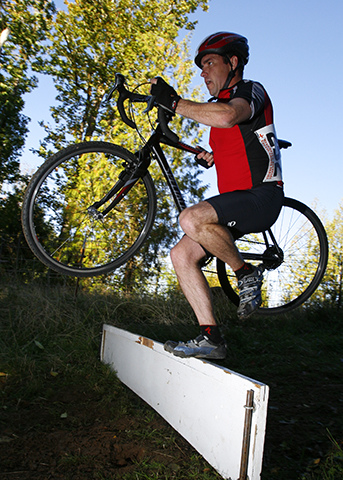

In [ ]:
def predicted_captiontest(rndm, autoplay=False) :

    cap_test_data = caption_val.copy()
    rid = 4600
    # rid = random.sample(range(0, rndm),2)
    real_cap_list=[]
    pred_cap_list=[]
    j=rid
    test_image=image_test[j]
    #print(len(cap_test_data))
    real_caption = ' '.join([tokenizer.index_word[i] for i in cap_test_data[j] if i not in [0]])
    #print(real_caption)
    result, attention_plot, pred_test = evaluate(test_image)
    real_caption=filt_text(real_caption)
    pred_caption=' '.join(result).rsplit(' ', 1)[0]
    real_appn = []
    real_appn.append(real_caption.split())
    real_cap_list.append(real_appn)
    pred_cap_list.append(pred_caption.split())

    #all_eval_method(test_image,real_cap_list, pred_cap_list)

    print ('Real Caption:', real_caption)
    print ('Prediction Caption:', pred_caption)
   # plot_attention_map(result, attention_plot, test_image)
    speech = gTTS('Predicted Caption : ' + pred_caption, lang = 'en', slow = False)
    speech.save('voice.mp3')
    audio_file = 'voice.mp3'

    display.display(display.Audio(audio_file, rate = None, autoplay = autoplay))

    return test_image

test_image = predicted_captiontest(len(image_test), True)
Image.open(test_image)

Real Caption: a man and child working on a puzzle
Prediction Caption: a older gentleman and an older gentleman


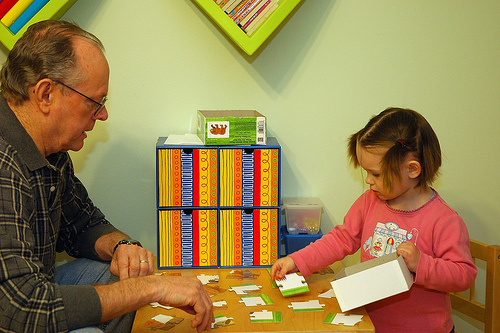

In [ ]:
def predicted_captiontest(rndm, autoplay=False) :

    cap_test_data = caption_val.copy()
    rid = 4800
    # rid = random.sample(range(0, rndm),2)
    real_cap_list=[]
    pred_cap_list=[]
    j=rid
    test_image=image_test[j]
    #print(len(cap_test_data))
    real_caption = ' '.join([tokenizer.index_word[i] for i in cap_test_data[j] if i not in [0]])
    #print(real_caption)
    result, attention_plot, pred_test = evaluate(test_image)
    real_caption=filt_text(real_caption)
    pred_caption=' '.join(result).rsplit(' ', 1)[0]
    real_appn = []
    real_appn.append(real_caption.split())
    real_cap_list.append(real_appn)
    pred_cap_list.append(pred_caption.split())

    #all_eval_method(test_image,real_cap_list, pred_cap_list)

    print ('Real Caption:', real_caption)
    print ('Prediction Caption:', pred_caption)
   # plot_attention_map(result, attention_plot, test_image)
    speech = gTTS('Predicted Caption : ' + pred_caption, lang = 'en', slow = False)
    speech.save('voice.mp3')
    audio_file = 'voice.mp3'

    display.display(display.Audio(audio_file, rate = None, autoplay = autoplay))

    return test_image

test_image = predicted_captiontest(len(image_test), True)
Image.open(test_image)

Real Caption: a man in a hat sitting at a bus stop on a laptop
Prediction Caption: a man is sitting at a bus stop


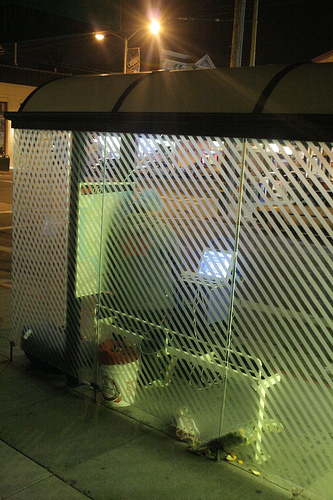

In [ ]:
def predicted_captiontest(rndm, autoplay=False) :

    cap_test_data = caption_val.copy()
    rid = 4900
    # rid = random.sample(range(0, rndm),2)
    real_cap_list=[]
    pred_cap_list=[]
    j=rid
    test_image=image_test[j]
    #print(len(cap_test_data))
    real_caption = ' '.join([tokenizer.index_word[i] for i in cap_test_data[j] if i not in [0]])
    #print(real_caption)
    result, attention_plot, pred_test = evaluate(test_image)
    real_caption=filt_text(real_caption)
    pred_caption=' '.join(result).rsplit(' ', 1)[0]
    real_appn = []
    real_appn.append(real_caption.split())
    real_cap_list.append(real_appn)
    pred_cap_list.append(pred_caption.split())

    #all_eval_method(test_image,real_cap_list, pred_cap_list)

    print ('Real Caption:', real_caption)
    print ('Prediction Caption:', pred_caption)
   # plot_attention_map(result, attention_plot, test_image)
    speech = gTTS('Predicted Caption : ' + pred_caption, lang = 'en', slow = False)
    speech.save('voice.mp3')
    audio_file = 'voice.mp3'

    display.display(display.Audio(audio_file, rate = None, autoplay = autoplay))

    return test_image

test_image = predicted_captiontest(len(image_test), True)
Image.open(test_image)